Imports

In [18]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import getpass
import matplotlib.pyplot as plt
from masks_S5 import masks
from masks_S2 import masks_S2
from sentinelhub import SentinelHubRequest, DataCollection, MimeType, CRS, BBox, SHConfig, Geometry

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

import os
from dotenv import load_dotenv
import numpy as np

load_dotenv()

True

Il faut se créer des OAuth sur https://shapps.dataspace.copernicus.eu/dashboard/#/ -> User settings -> en dessous de "OAuth clients" -> "Create" puis mettre un nom et copier ça dans un .env :

`SENTINEL_HUB_CLIENT_ID="esqfqesfqesffe-esffesqfes-fesqqefsqfes"`

`SENTINEL_HUB_CLIENT_SECRET="sjibiqb"`

In [2]:
config = SHConfig()
config.sh_client_id = os.getenv("SENTINEL_HUB_CLIENT_ID") or getpass.getpass("Enter your Sentinel Hub client ID: ")
config.sh_client_secret = os.getenv("SENTINEL_HUB_CLIENT_SECRET") or getpass.getpass("Enter your Sentinel Hub client secret: ")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"

config.save("takeair")

Résolution en mètres par pixel des images

In [3]:
resolution = 10 

Si on veut faire une request sur une bbox définie (http://bboxfinder.com)

In [4]:
bbox_coords: list[float] = [7.678671,48.517827,7.747207,48.536443]
bbox = BBox(bbox=bbox_coords, crs=CRS.WGS84)

Visualisation de tous les satellites disponibles : 

In [5]:
from sentinelhub import DataCollection

satellites = {}
for collection in DataCollection:
    try:
        satellites[collection.name] = [band.name for band in collection.bands]
    except:
        satellites[collection.name] = []

for satellite, bands in satellites.items():
    print(f"\n{satellite}:")
    if bands:
        for band in bands:
            print(f"- {band}")
    else:
        print("No bands available")



SENTINEL2_L1C:
- B01
- B02
- B03
- B04
- B05
- B06
- B07
- B08
- B8A
- B09
- B10
- B11
- B12

SENTINEL2_L2A:
- B01
- B02
- B03
- B04
- B05
- B06
- B07
- B08
- B8A
- B09
- B11
- B12

SENTINEL1:
No bands available

SENTINEL1_IW:
- VV
- VH

SENTINEL1_IW_ASC:
- VV
- VH

SENTINEL1_IW_DES:
- VV
- VH

SENTINEL1_EW:
- HH
- HV

SENTINEL1_EW_ASC:
- HH
- HV

SENTINEL1_EW_DES:
- HH
- HV

SENTINEL1_EW_SH:
- HH

SENTINEL1_EW_SH_ASC:
- HH

SENTINEL1_EW_SH_DES:
- HH

DEM:
- DEM

DEM_MAPZEN:
- DEM

DEM_COPERNICUS_30:
- DEM

DEM_COPERNICUS_90:
- DEM

MODIS:
- B01
- B02
- B03
- B04
- B05
- B06
- B07

LANDSAT_MSS_L1:
- B01
- B02
- B03
- B04

LANDSAT_TM_L1:
- B01
- B02
- B03
- B04
- B05
- B06
- B07

LANDSAT_TM_L2:
- B01
- B02
- B03
- B04
- B05
- B06
- B07

LANDSAT_ETM_L1:
- B01
- B02
- B03
- B04
- B05
- B06_VCID_1
- B06_VCID_2
- B07
- B08

LANDSAT_ETM_L2:
- B01
- B02
- B03
- B04
- B05
- B06
- B07

LANDSAT_OT_L1:
- B01
- B02
- B03
- B04
- B05
- B06
- B07
- B08
- B09
- B10
- B11

LANDSAT_OT_L2:
- B01
- B02


Simple affichage de tous les satellites disponibles :

In [6]:
for satellite in satellites:
    print(f"{satellite}")

SENTINEL2_L1C
SENTINEL2_L2A
SENTINEL1
SENTINEL1_IW
SENTINEL1_IW_ASC
SENTINEL1_IW_DES
SENTINEL1_EW
SENTINEL1_EW_ASC
SENTINEL1_EW_DES
SENTINEL1_EW_SH
SENTINEL1_EW_SH_ASC
SENTINEL1_EW_SH_DES
DEM
DEM_MAPZEN
DEM_COPERNICUS_30
DEM_COPERNICUS_90
MODIS
LANDSAT_MSS_L1
LANDSAT_TM_L1
LANDSAT_TM_L2
LANDSAT_ETM_L1
LANDSAT_ETM_L2
LANDSAT_OT_L1
LANDSAT_OT_L2
SENTINEL5P
SENTINEL3_OLCI
SENTINEL3_SLSTR
HARMONIZED_LANDSAT_SENTINEL


In [7]:
satellites['SENTINEL5P']

['CO',
 'HCHO',
 'NO2',
 'O3',
 'SO2',
 'CH4',
 'AER_AI_340_380',
 'AER_AI_354_388',
 'CLOUD_BASE_PRESSURE',
 'CLOUD_TOP_PRESSURE',
 'CLOUD_BASE_HEIGHT',
 'CLOUD_TOP_HEIGHT',
 'CLOUD_OPTICAL_THICKNESS',
 'CLOUD_FRACTION']

Requête sur le sentinel 2 : 

In [8]:
evalscript = """
//VERSION=3
let minVal = 0.0;
let maxVal = 0.4;

let viz = new HighlightCompressVisualizer(minVal, maxVal);

function setup(ds) {
  return {
    input: ["B03", "B04", "B08","dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(samples) {
    let val = [samples.B08, samples.B04, samples.B03,samples.dataMask];
    return viz.processList(val);
}
"""
bbox = BBox(bbox=[12.44693, 41.870072, 12.541001, 41.917096], crs=CRS.WGS84)

request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(name='s2l2a', service_url='https://sh.dataspace.copernicus.eu'),          
            time_interval=('2025-04-17', '2025-05-17'),          
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.JPG),
    ],
    bbox=bbox,
    size=[512, 343.697],
    config=config
)

response = request.get_data()
response

[array([[[204,  85,  91],
         [208,  84,  92],
         [210,  76,  85],
         ...,
         [194,  68,  71],
         [177,  84,  79],
         [178, 104,  95]],
 
        [[200,  90,  93],
         [206,  87,  93],
         [208,  74,  83],
         ...,
         [192,  63,  67],
         [172,  79,  74],
         [173,  99,  90]],
 
        [[195, 100,  98],
         [205,  96,  99],
         [214,  80,  89],
         ...,
         [185,  54,  59],
         [172,  79,  72],
         [184, 107,  97]],
 
        ...,
 
        [[198, 135, 130],
         [204, 141, 136],
         [184, 116, 113],
         ...,
         [189, 140, 135],
         [181, 132, 128],
         [169, 121, 117]],
 
        [[202, 141, 136],
         [200, 137, 132],
         [173, 105, 102],
         ...,
         [187, 138, 133],
         [184, 135, 131],
         [167, 119, 115]],
 
        [[220, 161, 155],
         [209, 148, 143],
         [201, 136, 130],
         ...,
         [183, 134, 129],
  

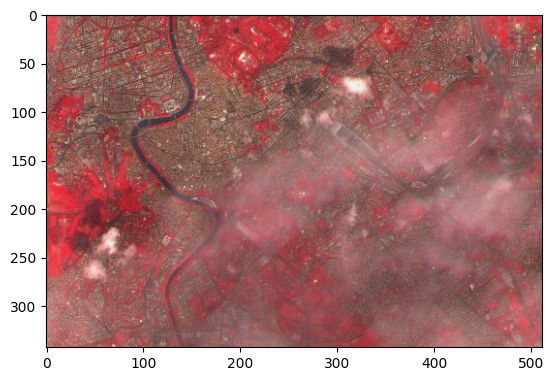

In [9]:
plt.imshow(response[0])
plt.show()

In [10]:
def request_S2(bbox, mask, resolution=(1481, 1538)):
    request = SentinelHubRequest(
        evalscript=mask,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(name='s2l2a', service_url='https://sh.dataspace.copernicus.eu'),          
                time_interval=('2025-04-17', '2025-05-17'),          
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.JPG),
        ],
        bbox=bbox,
        size=resolution,
        config=config
    )
    response = request.get_data()
    plt.imshow(response[0])
    plt.show()
    print(response[0])
    return response[0]

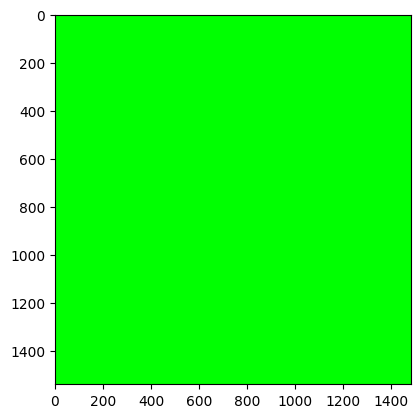

In [11]:
temperaturemask = '''
//VERSION=3

function setup() {
  return {
    input: ["S8", "S9", "dataMask"],
    output: [
      {
        id: "default",
        bands: 4
      },
      {
        id: "LST",
        bands: 1,
        sampleType: "FLOAT32"
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  };
}

function evaluatePixel(samples) {
  let T8 = samples.S8;
  let T9 = samples.S9;

  // Basic split-window algorithm
  // LST = T8 + a*(T8 - T9)
  // Here a = 0.5 (empirical, approximate)

  let LST = T8 + 0.5 * (T8 - T9);

  // Normalize for visualization (optional)
  let minTemp = 250; // K
  let maxTemp = 330; // K
  let norm = (LST - minTemp) / (maxTemp - minTemp);
  norm = Math.min(Math.max(norm, 0), 1);
  
  return {
    default: [norm, 1 - norm, 0, samples.dataMask],
    LST: [LST],
    dataMask: [samples.dataMask]
  };
}
'''

def request_SENTINEL3_SLSTR(bbox, mask, resolution=(1481, 1538)):
    request = SentinelHubRequest(
        evalscript=mask,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL3_SLSTR.define_from(name='s3slstr', service_url='https://sh.dataspace.copernicus.eu'),
                time_interval=('2025-04-17', '2025-05-14'),
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.JPG),
        ],
        bbox=bbox,
        size=resolution,
        config=config
    )
    response = request.get_data()
    plt.imshow(response[0])
    plt.show()
    return response[0]


response = request_SENTINEL3_SLSTR(bbox, temperaturemask, (1481, 1538))
from PIL import Image
img = Image.fromarray(response)
img.save("temperature.jpg")


In [12]:
bbox

BBox(((12.44693, 41.870072), (12.541001, 41.917096)), crs=CRS('4326'))

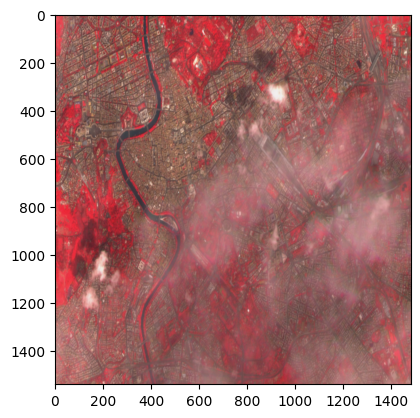

[[[207  76  81]
  [206  73  78]
  [213  76  86]
  ...
  [157 108  91]
  [149 106  87]
  [148 107  89]]

 [[215  82  87]
  [212  78  85]
  [218  81  91]
  ...
  [160 109  92]
  [152 107  88]
  [149 108  90]]

 [[216  81  88]
  [214  79  86]
  [218  81  91]
  ...
  [161 108  92]
  [155 108  90]
  [153 110  93]]

 ...

 [[215 155 147]
  [209 150 142]
  [207 148 140]
  ...
  [177 124 118]
  [174 121 115]
  [173 120 114]]

 [[225 162 155]
  [220 160 152]
  [219 158 153]
  ...
  [179 124 121]
  [174 119 116]
  [174 119 116]]

 [[225 162 155]
  [222 159 152]
  [221 158 153]
  ...
  [179 124 121]
  [174 119 116]
  [176 118 117]]]


array([[[207,  76,  81],
        [206,  73,  78],
        [213,  76,  86],
        ...,
        [157, 108,  91],
        [149, 106,  87],
        [148, 107,  89]],

       [[215,  82,  87],
        [212,  78,  85],
        [218,  81,  91],
        ...,
        [160, 109,  92],
        [152, 107,  88],
        [149, 108,  90]],

       [[216,  81,  88],
        [214,  79,  86],
        [218,  81,  91],
        ...,
        [161, 108,  92],
        [155, 108,  90],
        [153, 110,  93]],

       ...,

       [[215, 155, 147],
        [209, 150, 142],
        [207, 148, 140],
        ...,
        [177, 124, 118],
        [174, 121, 115],
        [173, 120, 114]],

       [[225, 162, 155],
        [220, 160, 152],
        [219, 158, 153],
        ...,
        [179, 124, 121],
        [174, 119, 116],
        [174, 119, 116]],

       [[225, 162, 155],
        [222, 159, 152],
        [221, 158, 153],
        ...,
        [179, 124, 121],
        [174, 119, 116],
        [176, 118, 117]]

In [13]:
imtc = """
//VERSION=3
let minVal = 0.0;
let maxVal = 0.4;

let viz = new HighlightCompressVisualizer(minVal, maxVal);

function setup(ds) {
  return {
    input: ["B03", "B04", "B08","dataMask"],
    output: { bands: 4 }
  };
}

function evaluatePixel(samples) {
    let val = [samples.B08, samples.B04, samples.B03,samples.dataMask];
    return viz.processList(val);
}
"""

request_S2(bbox, imtc)

Pour faire une request : 
On va sur le browser, on récupère le masque qu'on veut avec la function setup(), puis on la met dans le request builder et on récupère la request finale sentinelhub

In [14]:
def request_S5P(bbox_par, mask, resolution):
    data_5p = DataCollection.SENTINEL5P.define_from("s5p", service_url=config.sh_base_url)

    request_raw = SentinelHubRequest(
        evalscript=mask,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_5p,
                time_interval=("2023-05-16", "2025-05-16"),
            )
        ],
        responses=[SentinelHubRequest.output_response("index", MimeType.TIFF)],
        bbox=bbox_par,
        # Resolution is defined in units of the bbox crs! Be careful with WGS84 since this will be in degrees!
        # Since we have defined our bounding box in Web mercator the resolution is in meters.
        resolution=resolution,
        config=config,
        data_folder="./",  # We save the data in a specified folder
    )
    response = request_raw.get_data()
    plt.imshow(response[0])
    plt.show()
    return response[0]

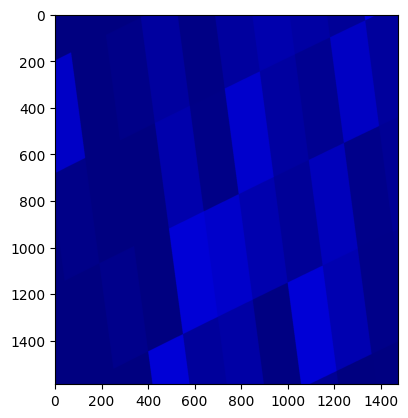

In [15]:
bbox_europe = BBox([-12.30, 34.59, 32.52, 63.15], crs=CRS.WGS84).transform(CRS(3857))

def create_bbox(coords, transform_to_3857=True):
    bbox = BBox(bbox=coords, crs=CRS.WGS84)
    if transform_to_3857:
        return bbox.transform(CRS(3857))
    return bbox

mt_st_odile_coords = [7.314835,48.426011,7.791367,48.596138]
grand_est_coords = [4.345093,47.051411,9.898682,49.278557]
bbox_mt_st_odile = create_bbox(mt_st_odile_coords)
bbox_grand_est = create_bbox(grand_est_coords) 

response = request_S5P(bbox_par=bbox_mt_st_odile, mask=masks['AER_AI'], resolution=bbox_to_dimensions(bbox_mt_st_odile, resolution=1000))

In [22]:
from shapely.geometry import box
from pyproj import Transformer

def calculate_masks(person_coordinates, radius_kilometers, resolution=300):
    lon, lat = person_coordinates
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    x_center, y_center = transformer.transform(lon, lat)

    x_min = x_center - radius_kilometers * 1000
    x_max = x_center + radius_kilometers * 1000
    y_min = y_center - radius_kilometers * 1000
    y_max = y_center + radius_kilometers * 1000

    bbox_3857 = BBox(bbox=[x_min, y_min, x_max, y_max], crs=CRS.POP_WEB)

    responses = []
    i = 0

    for mask_name, mask_script in masks.items():
        if mask_name == "UV":
            continue
        print(f"Requesting mask: {mask_name}")
        response = request_S5P(
            bbox_par=bbox_3857,
            mask=mask_script,
            resolution=bbox_to_dimensions(bbox_3857, resolution)
        )
        if mask_name in ["NO2", "AER_AI", "O3", "CO", "SO2", "HCHO", "CH4"]:
            responses.append(response)
    return bbox_3857, responses

Requesting mask: AER_AI


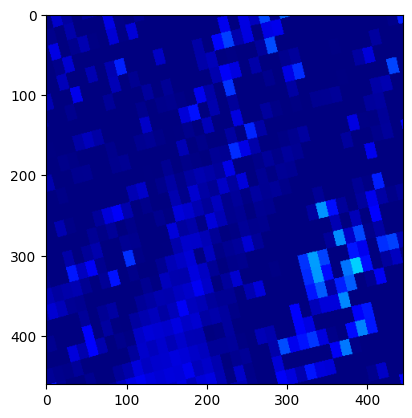

Requesting mask: METHANE


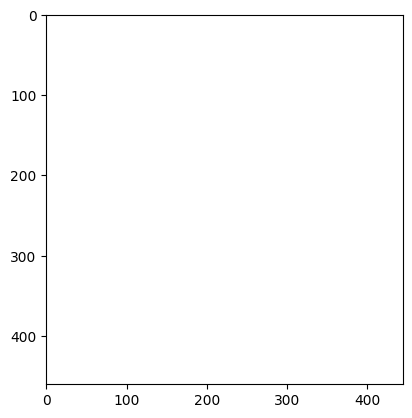

Requesting mask: CLOUD_HEIGHT


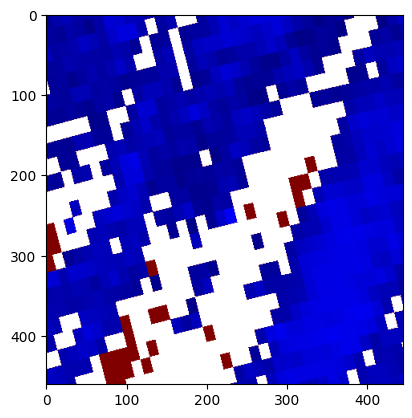

Requesting mask: CLOUD_PRESSURE


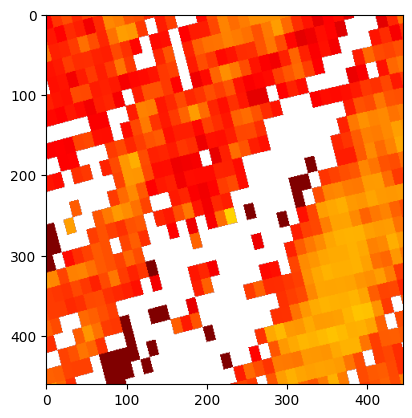

Requesting mask: CLOUD_EFFECTIVE_RADIOMETRIC_FRACTION


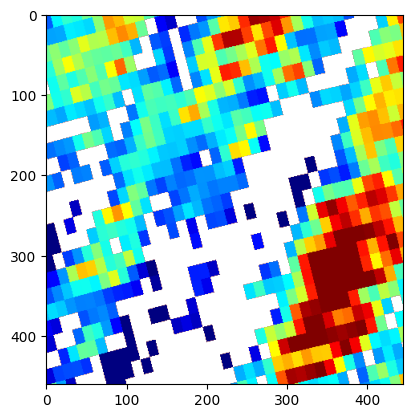

Requesting mask: CLOUD_OPTICAL_THICKNESS


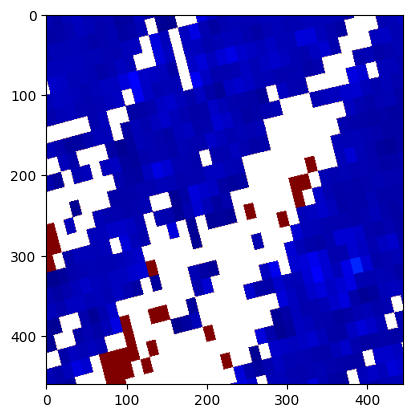

Requesting mask: CO


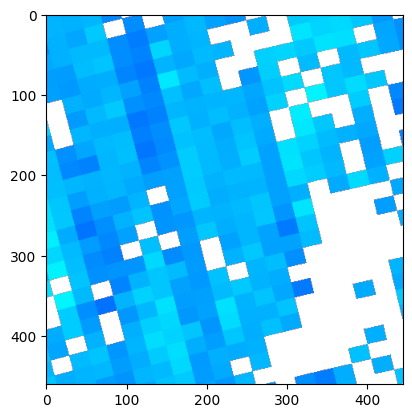

Requesting mask: HCHO


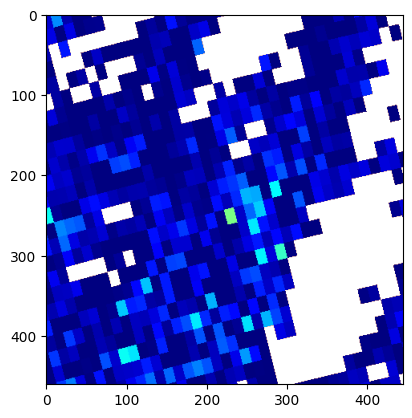

Requesting mask: NO2


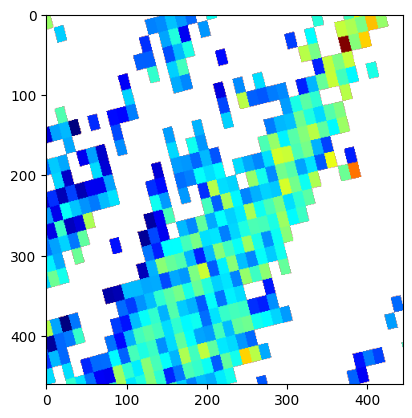

Requesting mask: SO2


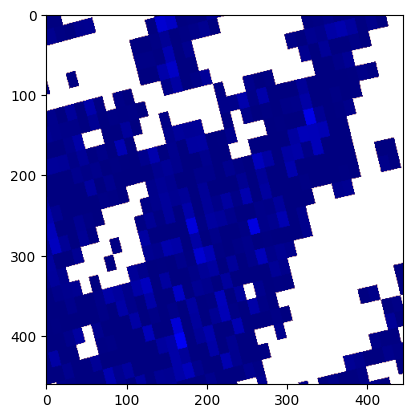

In [23]:
isu_coordinates = [7.736971,48.523071]
bbox, responses = calculate_masks(isu_coordinates, 100, resolution=300)

In [364]:
bbox_to_dimensions(bbox, resolution=11000)

(12, 12)

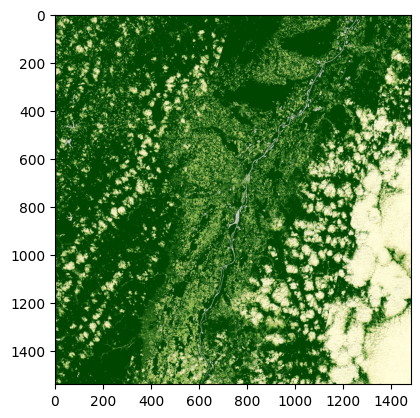

[[[ 10  83  14]
  [ 27  96  29]
  [  7  68   8]
  ...
  [255 252 212]
  [255 249 220]
  [255 249 223]]

 [[ 42 112  42]
  [  5  75   3]
  [  0  64   0]
  ...
  [222 219 178]
  [229 222 194]
  [255 252 227]]

 [[ 20  84  10]
  [ 72 141  61]
  [  0  74   0]
  ...
  [255 255 218]
  [254 248 224]
  [255 251 231]]

 ...

 [[  1  73   0]
  [  0  66   0]
  [  0  69   4]
  ...
  [254 249 217]
  [254 250 215]
  [253 249 212]]

 [[  0  70   0]
  [  0  70   0]
  [  0  69   2]
  ...
  [255 255 222]
  [255 254 221]
  [255 254 221]]

 [[  0  70   0]
  [  0  70   0]
  [  0  70   0]
  ...
  [255 255 222]
  [255 254 221]
  [255 254 223]]]


In [380]:
response2 = request_S2(bbox, masks_S2['NDVI'], (1481, 1538))

In [368]:
responses[0].shape

(1538, 1481, 4)

Poids pour la pondération en w1 * NO2 + w2 * AER_AI + w3 * O3 + w4 * CO + w5 * SO2 + w6 * HCHO + w7 * CH4 pour les 7 masques obtenus en raw values

(np.float64(-0.5), np.float64(444.5), np.float64(460.5), np.float64(-0.5))

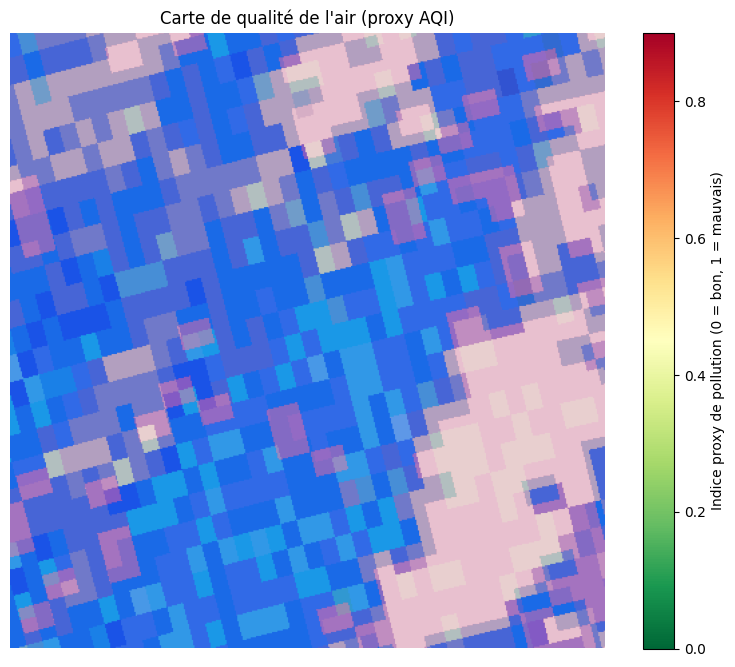

In [ ]:
# Seuils "typique maximum" (approximés) pour normalisation
THRESHOLDS = {
    "NO2": 0.0001,         # mol/m²
    "AER_AI": 5.0,         # unitless
    "O3": 0.36,            # mol/m²
    "CO": 0.1,             # mol/m²
    "SO2": 0.01,           # mol/m²
    "HCHO": 0.001,         # mol/m²
    "CH4": 2000.0          # ppb or scaled mol
}

# Poids selon dangerosité
WEIGHTS = {
    "NO2": 0.25,
    "AER_AI": 0.25,
    "O3": 0.20,
    "CO": 0.10,
    "SO2": 0.10,
    "HCHO": 0.05,
    "CH4": 0.05
}

def calculate_risk_score(responses, selected_keys=None):
    """
    Calcule une image AQI proxy normalisée et pondérée.
    
    Args:
        responses (list): liste des images (np.array) issues de calculate_masks
        selected_keys (list): ordre des polluants correspondant aux réponses
    
    Returns:
        np.array: image AQI proxy
    """
    if selected_keys is None:
        selected_keys = ["NO2", "AER_AI", "O3", "CO", "SO2", "HCHO", "CH4"]

    aqi_proxy = np.zeros_like(responses[0], dtype=np.float32)

    for i, key in enumerate(selected_keys):
        if i >= len(responses):
            break
        data = responses[i].astype(np.float32)
        threshold = THRESHOLDS.get(key)
        weight = WEIGHTS.get(key)

        if threshold is None or weight is None:
            print(f"Polluant inconnu ou sans seuil/poids : {key}")
            continue

        # Normalisation et pondération
        normalized = np.clip(data / threshold, 0, 1)
        weighted = normalized * weight
        aqi_proxy += weighted

    return aqi_proxy

aqi_image = calculate_risk_score(responses)
plt.figure(figsize=(10, 8))
plt.imshow(aqi_image, cmap='RdYlGn_r')  # vert = bon, rouge = mauvais
plt.colorbar(label="Indice proxy de pollution (0 = bon, 1 = mauvais)")
plt.title("Carte de qualité de l'air (proxy AQI)")
plt.axis("off")


In [25]:
responses

[array([[[  0,   0, 128, 255],
         [  0,   0, 128, 255],
         [  0,   0, 128, 255],
         ...,
         [  0,  28, 255, 255],
         [  0,  28, 255, 255],
         [  0,  28, 255, 255]],
 
        [[  0,   0, 128, 255],
         [  0,   0, 128, 255],
         [  0,   0, 128, 255],
         ...,
         [  0,  28, 255, 255],
         [  0,  28, 255, 255],
         [  0,  28, 255, 255]],
 
        [[  0,   0, 128, 255],
         [  0,   0, 128, 255],
         [  0,   0, 128, 255],
         ...,
         [  0,  28, 255, 255],
         [  0,  28, 255, 255],
         [  0,  28, 255, 255]],
 
        ...,
 
        [[  0,   0, 150, 255],
         [  0,   0, 150, 255],
         [  0,   0, 150, 255],
         ...,
         [  0,   0, 244, 255],
         [  0,   0, 244, 255],
         [  0,   0, 244, 255]],
 
        [[  0,   0, 150, 255],
         [  0,   0, 150, 255],
         [  0,   0, 150, 255],
         ...,
         [  0,   0, 244, 255],
         [  0,   0, 244, 255],
    

In [33]:
aqi_image

array([[[0.1       , 0.35      , 0.90000004, 0.90000004],
        [0.1       , 0.35      , 0.90000004, 0.90000004],
        [0.1       , 0.35      , 0.90000004, 0.90000004],
        ...,
        [0.65000004, 0.25      , 0.25      , 0.25      ],
        [0.65000004, 0.25      , 0.25      , 0.25      ],
        [0.65000004, 0.25      , 0.25      , 0.25      ]],

       [[0.1       , 0.35      , 0.90000004, 0.90000004],
        [0.1       , 0.35      , 0.90000004, 0.90000004],
        [0.1       , 0.35      , 0.90000004, 0.90000004],
        ...,
        [0.65000004, 0.25      , 0.25      , 0.25      ],
        [0.65000004, 0.25      , 0.25      , 0.25      ],
        [0.65000004, 0.25      , 0.25      , 0.25      ]],

       [[0.1       , 0.35      , 0.90000004, 0.90000004],
        [0.1       , 0.35      , 0.90000004, 0.90000004],
        [0.1       , 0.35      , 0.90000004, 0.90000004],
        ...,
        [0.65000004, 0.25      , 0.25      , 0.25      ],
        [0.65000004, 0.25    